In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, \
                                    Flatten, Conv1D, MaxPooling1D, Dropout, \
                                    Concatenate, GlobalMaxPool1D, GlobalAvgPool1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_cnn(conv_num=1):
    filter_size = 128

    input_layer = Input(shape=input_shape)
    x = input_layer

    layer_outputs = []
    for i in range(conv_num):
        x = Conv1D (kernel_size=5, filters=filter_size*(2**(i//4)), 
                          strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(pool_size=3, strides=3)(x)
        layer_outputs.append(x)    
    
    x = Concatenate()([GlobalMaxPool1D()(output) for output in layer_outputs[-2:]])
    x = Dropout(0.5)(x)
    x = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=x)
    return model

In [9]:
for i in range(3, 9):
    model = build_cnn(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 16000, 128)   768         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 16000, 128)   512         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activatio

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 16000, 128)   768         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_7 (Batch (None, 16000, 128)   512         conv1d_7[0][0]                   
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 16000, 128)   0           batch_normalization_v1_7[0][0]   
__________________________________________________________________________________________________
max_poolin

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 16000, 128)   768         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_18 (Batc (None, 16000, 128)   512         conv1d_18[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 16000, 128)   0           batch_normalization_v1_18[0][0]  
__________________________________________________________________________________________________
max_poolin

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 6.0122 - acc: 0.1226
Epoch 00001: val_loss improved from inf to 2.25628, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_DO_BN_3_conv_checkpoint/001-2.2563.hdf5
36805/36805 [==============================] - 106s 3ms/sample - loss: 6.0119 - acc: 0.1225 - val_loss: 2.2563 - val_acc: 0.2833
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.6644 - acc: 0.1616
Epoch 00002: val_loss improved from 2.25628 to 1.88674, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_DO_BN_3_conv_checkpoint/002-1.8867.hdf5
36805/36805 [==============================] - 102s 3ms/sample - loss: 3.6644 - acc: 0.1616 - val_loss: 1.8867 - val_acc: 0.4165
Epoch 3/500
36800/36805 [============================>.

Epoch 21/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0788 - acc: 0.6493
Epoch 00021: val_loss improved from 0.77376 to 0.76157, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_DO_BN_3_conv_checkpoint/021-0.7616.hdf5
36805/36805 [==============================] - 102s 3ms/sample - loss: 1.0788 - acc: 0.6494 - val_loss: 0.7616 - val_acc: 0.7729
Epoch 22/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0559 - acc: 0.6544
Epoch 00022: val_loss improved from 0.76157 to 0.72251, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_DO_BN_3_conv_checkpoint/022-0.7225.hdf5
36805/36805 [==============================] - 102s 3ms/sample - loss: 1.0559 - acc: 0.6544 - val_loss: 0.7225 - val_acc: 0.7911
Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0456 - acc: 0.6615
Epoch 00023: val_loss improved from 0.72251 to 0.71119, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_DO_BN

Epoch 45/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7923 - acc: 0.7471
Epoch 00045: val_loss improved from 0.57503 to 0.56308, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_DO_BN_3_conv_checkpoint/045-0.5631.hdf5
36805/36805 [==============================] - 102s 3ms/sample - loss: 0.7923 - acc: 0.7471 - val_loss: 0.5631 - val_acc: 0.8381
Epoch 46/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7856 - acc: 0.7502
Epoch 00046: val_loss did not improve from 0.56308
36805/36805 [==============================] - 102s 3ms/sample - loss: 0.7856 - acc: 0.7501 - val_loss: 0.5859 - val_acc: 0.8258
Epoch 47/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7823 - acc: 0.7530
Epoch 00047: val_loss did not improve from 0.56308
36805/36805 [==============================] - 102s 3ms/sample - loss: 0.7823 - acc: 0.7530 - val_loss: 0.5681 - val_acc: 0.8323
Epoch 48/500
36800/36805 [============================>.] 

Epoch 71/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6797 - acc: 0.7837
Epoch 00071: val_loss improved from 0.50071 to 0.49021, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_DO_BN_3_conv_checkpoint/071-0.4902.hdf5
36805/36805 [==============================] - 102s 3ms/sample - loss: 0.6798 - acc: 0.7836 - val_loss: 0.4902 - val_acc: 0.8577
Epoch 72/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6762 - acc: 0.7868
Epoch 00072: val_loss did not improve from 0.49021
36805/36805 [==============================] - 102s 3ms/sample - loss: 0.6763 - acc: 0.7868 - val_loss: 0.5159 - val_acc: 0.8493
Epoch 73/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6697 - acc: 0.7871
Epoch 00073: val_loss did not improve from 0.49021
36805/36805 [==============================] - 102s 3ms/sample - loss: 0.6697 - acc: 0.7871 - val_loss: 0.4911 - val_acc: 0.8623
Epoch 74/500
36800/36805 [============================>.] 

Epoch 99/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5967 - acc: 0.8093
Epoch 00099: val_loss did not improve from 0.45439
36805/36805 [==============================] - 102s 3ms/sample - loss: 0.5967 - acc: 0.8093 - val_loss: 0.4612 - val_acc: 0.8661
Epoch 100/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5969 - acc: 0.8128
Epoch 00100: val_loss did not improve from 0.45439
36805/36805 [==============================] - 102s 3ms/sample - loss: 0.5968 - acc: 0.8128 - val_loss: 0.4680 - val_acc: 0.8689
Epoch 101/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5975 - acc: 0.8125
Epoch 00101: val_loss did not improve from 0.45439
36805/36805 [==============================] - 102s 3ms/sample - loss: 0.5977 - acc: 0.8125 - val_loss: 0.4805 - val_acc: 0.8558
Epoch 102/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5944 - acc: 0.8110
Epoch 00102: val_loss did not improve from 0.45439
36805/36805 [=====

Epoch 127/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5316 - acc: 0.8316
Epoch 00127: val_loss did not improve from 0.42320
36805/36805 [==============================] - 102s 3ms/sample - loss: 0.5316 - acc: 0.8316 - val_loss: 0.4771 - val_acc: 0.8623
Epoch 128/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5389 - acc: 0.8289
Epoch 00128: val_loss did not improve from 0.42320
36805/36805 [==============================] - 102s 3ms/sample - loss: 0.5389 - acc: 0.8289 - val_loss: 0.4377 - val_acc: 0.8772
Epoch 129/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5386 - acc: 0.8273
Epoch 00129: val_loss did not improve from 0.42320
36805/36805 [==============================] - 102s 3ms/sample - loss: 0.5385 - acc: 0.8274 - val_loss: 0.4551 - val_acc: 0.8710
Epoch 130/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5336 - acc: 0.8287
Epoch 00130: val_loss did not improve from 0.42320
36805/36805 [====

36800/36805 [============================>.] - ETA: 0s - loss: 0.4968 - acc: 0.8421
Epoch 00156: val_loss did not improve from 0.42023
36805/36805 [==============================] - 102s 3ms/sample - loss: 0.4967 - acc: 0.8421 - val_loss: 0.4704 - val_acc: 0.8551
Epoch 157/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5044 - acc: 0.8387
Epoch 00157: val_loss did not improve from 0.42023
36805/36805 [==============================] - 102s 3ms/sample - loss: 0.5045 - acc: 0.8387 - val_loss: 0.4245 - val_acc: 0.8730
Epoch 158/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4995 - acc: 0.8407
Epoch 00158: val_loss improved from 0.42023 to 0.41789, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_DO_BN_3_conv_checkpoint/158-0.4179.hdf5
36805/36805 [==============================] - 102s 3ms/sample - loss: 0.4995 - acc: 0.8407 - val_loss: 0.4179 - val_acc: 0.8772
Epoch 159/500
36800/36805 [============================>.] - ETA: 0s 

36800/36805 [============================>.] - ETA: 0s - loss: 0.4577 - acc: 0.8531
Epoch 00185: val_loss did not improve from 0.41789
36805/36805 [==============================] - 102s 3ms/sample - loss: 0.4578 - acc: 0.8531 - val_loss: 0.4389 - val_acc: 0.8679
Epoch 186/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4567 - acc: 0.8538
Epoch 00186: val_loss did not improve from 0.41789
36805/36805 [==============================] - 102s 3ms/sample - loss: 0.4566 - acc: 0.8538 - val_loss: 0.4477 - val_acc: 0.8679
Epoch 187/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4523 - acc: 0.8549
Epoch 00187: val_loss did not improve from 0.41789
36805/36805 [==============================] - 102s 3ms/sample - loss: 0.4524 - acc: 0.8549 - val_loss: 0.4491 - val_acc: 0.8644
Epoch 188/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4563 - acc: 0.8548
Epoch 00188: val_loss did not improve from 0.41789
36805/36805 [==================

36800/36805 [============================>.] - ETA: 0s - loss: 0.4259 - acc: 0.8627
Epoch 00214: val_loss did not improve from 0.40199
36805/36805 [==============================] - 102s 3ms/sample - loss: 0.4259 - acc: 0.8627 - val_loss: 0.4399 - val_acc: 0.8691
Epoch 215/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4259 - acc: 0.8628
Epoch 00215: val_loss did not improve from 0.40199
36805/36805 [==============================] - 102s 3ms/sample - loss: 0.4258 - acc: 0.8628 - val_loss: 0.4222 - val_acc: 0.8756
Epoch 216/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4202 - acc: 0.8644
Epoch 00216: val_loss did not improve from 0.40199
36805/36805 [==============================] - 102s 3ms/sample - loss: 0.4202 - acc: 0.8644 - val_loss: 0.4271 - val_acc: 0.8747
Epoch 217/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4211 - acc: 0.8650
Epoch 00217: val_loss did not improve from 0.40199
36805/36805 [==================

Epoch 244/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3948 - acc: 0.8742
Epoch 00244: val_loss did not improve from 0.40199
36805/36805 [==============================] - 102s 3ms/sample - loss: 0.3948 - acc: 0.8743 - val_loss: 0.4443 - val_acc: 0.8661
Epoch 245/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3908 - acc: 0.8737
Epoch 00245: val_loss did not improve from 0.40199
36805/36805 [==============================] - 102s 3ms/sample - loss: 0.3907 - acc: 0.8737 - val_loss: 0.4704 - val_acc: 0.8563
Epoch 246/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3918 - acc: 0.8731
Epoch 00246: val_loss did not improve from 0.40199
36805/36805 [==============================] - 102s 3ms/sample - loss: 0.3920 - acc: 0.8731 - val_loss: 0.4626 - val_acc: 0.8607
Epoch 247/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3892 - acc: 0.8737
Epoch 00247: val_loss did not improve from 0.40199
36805/36805 [====

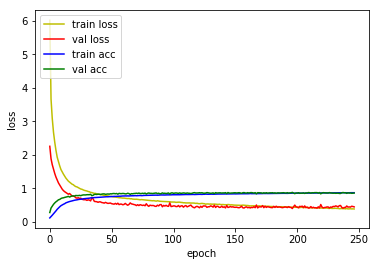

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.5020 - acc: 0.8478
Loss: 0.5019714470840565 Accuracy: 0.8477674

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 5.1425 - acc: 0.1416
Epoch 00001: val_loss improved from inf to 2.08947, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_DO_BN_4_conv_checkpoint/001-2.0895.hdf5
36805/36805 [==============================] - 109s 3ms/sample - loss: 5.1424 - acc: 0.1416 - val_loss: 2.0895 - val_acc: 0.3098
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.0519 - acc: 0.2218
Epoch 00002: val_loss improved from 2.08947 to 1.51677, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_DO_BN_4_conv_checkpoint/002-1.5168.hdf5
36805/36805 [==============================] - 105s 3ms/sample - loss: 3.0518 - acc: 0.2219 - val_loss: 1.5168 - val_acc: 0.5197
Epoch 3/500
36800/36805 [======================

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6962 - acc: 0.7808
Epoch 00023: val_loss improved from 0.44712 to 0.44020, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_DO_BN_4_conv_checkpoint/023-0.4402.hdf5
36805/36805 [==============================] - 105s 3ms/sample - loss: 0.6961 - acc: 0.7808 - val_loss: 0.4402 - val_acc: 0.8644
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6736 - acc: 0.7888
Epoch 00024: val_loss improved from 0.44020 to 0.42969, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_DO_BN_4_conv_checkpoint/024-0.4297.hdf5
36805/36805 [==============================] - 105s 3ms/sample - loss: 0.6735 - acc: 0.7889 - val_loss: 0.4297 - val_acc: 0.8779
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6603 - acc: 0.7921
Epoch 00025: val_loss improved from 0.42969 to 0.41328, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_DO_BN

Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4681 - acc: 0.8517
Epoch 00049: val_loss did not improve from 0.33830
36805/36805 [==============================] - 104s 3ms/sample - loss: 0.4681 - acc: 0.8517 - val_loss: 0.3509 - val_acc: 0.8982
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4646 - acc: 0.8571
Epoch 00050: val_loss did not improve from 0.33830
36805/36805 [==============================] - 105s 3ms/sample - loss: 0.4647 - acc: 0.8570 - val_loss: 0.3425 - val_acc: 0.8968
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4582 - acc: 0.8551
Epoch 00051: val_loss did not improve from 0.33830
36805/36805 [==============================] - 104s 3ms/sample - loss: 0.4581 - acc: 0.8551 - val_loss: 0.3410 - val_acc: 0.9012
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4533 - acc: 0.8588
Epoch 00052: val_loss did not improve from 0.33830
36805/36805 [========

Epoch 77/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3743 - acc: 0.8846
Epoch 00077: val_loss did not improve from 0.28568
36805/36805 [==============================] - 105s 3ms/sample - loss: 0.3743 - acc: 0.8846 - val_loss: 0.2919 - val_acc: 0.9140
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3608 - acc: 0.8882
Epoch 00078: val_loss did not improve from 0.28568
36805/36805 [==============================] - 104s 3ms/sample - loss: 0.3608 - acc: 0.8881 - val_loss: 0.3029 - val_acc: 0.9108
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3624 - acc: 0.8870
Epoch 00079: val_loss did not improve from 0.28568
36805/36805 [==============================] - 104s 3ms/sample - loss: 0.3623 - acc: 0.8870 - val_loss: 0.3029 - val_acc: 0.9099
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3573 - acc: 0.8880
Epoch 00080: val_loss improved from 0.28568 to 0.28397, saving model to 

Epoch 105/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2906 - acc: 0.9080
Epoch 00105: val_loss did not improve from 0.26622
36805/36805 [==============================] - 104s 3ms/sample - loss: 0.2906 - acc: 0.9080 - val_loss: 0.2684 - val_acc: 0.9220
Epoch 106/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2940 - acc: 0.9100
Epoch 00106: val_loss did not improve from 0.26622
36805/36805 [==============================] - 104s 3ms/sample - loss: 0.2940 - acc: 0.9100 - val_loss: 0.2757 - val_acc: 0.9164
Epoch 107/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2915 - acc: 0.9095
Epoch 00107: val_loss did not improve from 0.26622
36805/36805 [==============================] - 104s 3ms/sample - loss: 0.2915 - acc: 0.9094 - val_loss: 0.2719 - val_acc: 0.9224
Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2937 - acc: 0.9089
Epoch 00108: val_loss did not improve from 0.26622
36805/36805 [====

36800/36805 [============================>.] - ETA: 0s - loss: 0.2476 - acc: 0.9210
Epoch 00133: val_loss did not improve from 0.26281
36805/36805 [==============================] - 104s 3ms/sample - loss: 0.2477 - acc: 0.9210 - val_loss: 0.2753 - val_acc: 0.9185
Epoch 134/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2433 - acc: 0.9225
Epoch 00134: val_loss did not improve from 0.26281
36805/36805 [==============================] - 104s 3ms/sample - loss: 0.2434 - acc: 0.9225 - val_loss: 0.2658 - val_acc: 0.9234
Epoch 135/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2437 - acc: 0.9240
Epoch 00135: val_loss did not improve from 0.26281
36805/36805 [==============================] - 104s 3ms/sample - loss: 0.2437 - acc: 0.9240 - val_loss: 0.2632 - val_acc: 0.9234
Epoch 136/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2339 - acc: 0.9247
Epoch 00136: val_loss did not improve from 0.26281
36805/36805 [==================

36800/36805 [============================>.] - ETA: 0s - loss: 0.2122 - acc: 0.9329
Epoch 00162: val_loss did not improve from 0.25750
36805/36805 [==============================] - 104s 3ms/sample - loss: 0.2122 - acc: 0.9329 - val_loss: 0.2664 - val_acc: 0.9224
Epoch 163/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2026 - acc: 0.9359
Epoch 00163: val_loss did not improve from 0.25750
36805/36805 [==============================] - 104s 3ms/sample - loss: 0.2026 - acc: 0.9359 - val_loss: 0.3037 - val_acc: 0.9080
Epoch 164/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2050 - acc: 0.9347
Epoch 00164: val_loss did not improve from 0.25750
36805/36805 [==============================] - 104s 3ms/sample - loss: 0.2050 - acc: 0.9347 - val_loss: 0.2828 - val_acc: 0.9154
Epoch 165/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2012 - acc: 0.9368
Epoch 00165: val_loss did not improve from 0.25750
36805/36805 [==================

Epoch 192/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1729 - acc: 0.9448
Epoch 00192: val_loss did not improve from 0.25750
36805/36805 [==============================] - 104s 3ms/sample - loss: 0.1730 - acc: 0.9448 - val_loss: 0.3019 - val_acc: 0.9057
Epoch 193/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1746 - acc: 0.9452
Epoch 00193: val_loss did not improve from 0.25750
36805/36805 [==============================] - 104s 3ms/sample - loss: 0.1745 - acc: 0.9452 - val_loss: 0.2823 - val_acc: 0.9189
Epoch 194/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1700 - acc: 0.9461
Epoch 00194: val_loss did not improve from 0.25750
36805/36805 [==============================] - 104s 3ms/sample - loss: 0.1700 - acc: 0.9461 - val_loss: 0.3093 - val_acc: 0.9087
Epoch 195/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1731 - acc: 0.9459
Epoch 00195: val_loss did not improve from 0.25750
36805/36805 [====

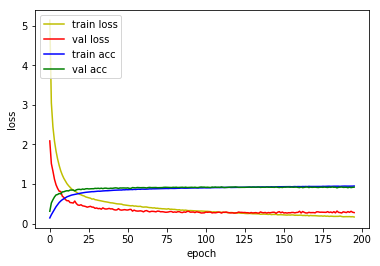

4815/4815 [==============================] - 5s 991us/sample - loss: 0.3377 - acc: 0.8974
Loss: 0.3376808849698163 Accuracy: 0.89740396

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 4.3531 - acc: 0.2138
Epoch 00001: val_loss improved from inf to 1.59617, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_DO_BN_5_conv_checkpoint/001-1.5962.hdf5
36805/36805 [==============================] - 112s 3ms/sample - loss: 4.3527 - acc: 0.2139 - val_loss: 1.5962 - val_acc: 0.4875
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2400 - acc: 0.4093
Epoch 00002: val_loss improved from 1.59617 to 0.80921, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_DO_BN_5_conv_checkpoint/002-0.8092.hdf5
36805/36805 [==============================] - 107s 3ms/sample - loss: 2.2398 - acc: 0.4094 - val_loss: 0.8092 - val_acc: 0.7358
Epoch 3/500
36800/36805 [===================

36800/36805 [============================>.] - ETA: 0s - loss: 0.3370 - acc: 0.8946
Epoch 00024: val_loss improved from 0.21627 to 0.19985, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_DO_BN_5_conv_checkpoint/024-0.1998.hdf5
36805/36805 [==============================] - 107s 3ms/sample - loss: 0.3370 - acc: 0.8946 - val_loss: 0.1998 - val_acc: 0.9376
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3283 - acc: 0.8957
Epoch 00025: val_loss did not improve from 0.19985
36805/36805 [==============================] - 107s 3ms/sample - loss: 0.3284 - acc: 0.8957 - val_loss: 0.2082 - val_acc: 0.9392
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3204 - acc: 0.8997
Epoch 00026: val_loss improved from 0.19985 to 0.18999, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_DO_BN_5_conv_checkpoint/026-0.1900.hdf5
36805/36805 [==============================] - 107s 3ms/sample - loss: 0.3204 - acc: 0.89

Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1858 - acc: 0.9400
Epoch 00051: val_loss did not improve from 0.15835
36805/36805 [==============================] - 107s 3ms/sample - loss: 0.1858 - acc: 0.9400 - val_loss: 0.1608 - val_acc: 0.9511
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1789 - acc: 0.9431
Epoch 00052: val_loss did not improve from 0.15835
36805/36805 [==============================] - 107s 3ms/sample - loss: 0.1789 - acc: 0.9431 - val_loss: 0.1769 - val_acc: 0.9464
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1781 - acc: 0.9433
Epoch 00053: val_loss did not improve from 0.15835
36805/36805 [==============================] - 107s 3ms/sample - loss: 0.1781 - acc: 0.9433 - val_loss: 0.1758 - val_acc: 0.9462
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1750 - acc: 0.9438
Epoch 00054: val_loss improved from 0.15835 to 0.15417, saving model to 

36800/36805 [============================>.] - ETA: 0s - loss: 0.1017 - acc: 0.9676
Epoch 00080: val_loss did not improve from 0.15417
36805/36805 [==============================] - 107s 3ms/sample - loss: 0.1017 - acc: 0.9676 - val_loss: 0.1617 - val_acc: 0.9497
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1027 - acc: 0.9670
Epoch 00081: val_loss did not improve from 0.15417
36805/36805 [==============================] - 107s 3ms/sample - loss: 0.1027 - acc: 0.9670 - val_loss: 0.1721 - val_acc: 0.9504
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0971 - acc: 0.9684
Epoch 00082: val_loss did not improve from 0.15417
36805/36805 [==============================] - 107s 3ms/sample - loss: 0.0971 - acc: 0.9684 - val_loss: 0.2199 - val_acc: 0.9369
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0992 - acc: 0.9678
Epoch 00083: val_loss did not improve from 0.15417
36805/36805 [=====================

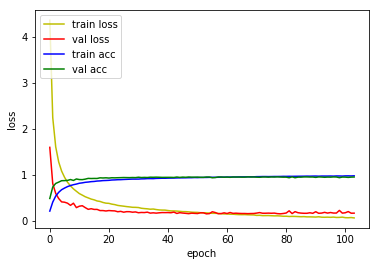

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.1841 - acc: 0.9404
Loss: 0.18406000310634404 Accuracy: 0.9403946

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.1766 - acc: 0.3445
Epoch 00001: val_loss improved from inf to 1.09616, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_DO_BN_6_conv_checkpoint/001-1.0962.hdf5
36805/36805 [==============================] - 116s 3ms/sample - loss: 3.1770 - acc: 0.3445 - val_loss: 1.0962 - val_acc: 0.6380
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3318 - acc: 0.6319
Epoch 00002: val_loss improved from 1.09616 to 0.42718, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_DO_BN_6_conv_checkpoint/002-0.4272.hdf5
36805/36805 [==============================] - 109s 3ms/sample - loss: 1.3317 - acc: 0.6319 - val_loss: 0.4272 - val_acc: 0.8744
Epoch 3/500
36800/36805 [=====================

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1779 - acc: 0.9443
Epoch 00025: val_loss did not improve from 0.12057
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.1779 - acc: 0.9443 - val_loss: 0.1255 - val_acc: 0.9595
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1647 - acc: 0.9467
Epoch 00026: val_loss did not improve from 0.12057
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.1647 - acc: 0.9467 - val_loss: 0.1237 - val_acc: 0.9627
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1565 - acc: 0.9483
Epoch 00027: val_loss did not improve from 0.12057
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.1565 - acc: 0.9482 - val_loss: 0.1279 - val_acc: 0.9604
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1561 - acc: 0.9499
Epoch 00028: val_loss did not improve from 0.12057
36805/36805 [========

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0661 - acc: 0.9785
Epoch 00054: val_loss did not improve from 0.10892
36805/36805 [==============================] - 107s 3ms/sample - loss: 0.0661 - acc: 0.9785 - val_loss: 0.1221 - val_acc: 0.9651
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0618 - acc: 0.9804
Epoch 00055: val_loss did not improve from 0.10892
36805/36805 [==============================] - 107s 3ms/sample - loss: 0.0618 - acc: 0.9804 - val_loss: 0.1631 - val_acc: 0.9520
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0656 - acc: 0.9780
Epoch 00056: val_loss did not improve from 0.10892
36805/36805 [==============================] - 107s 3ms/sample - loss: 0.0656 - acc: 0.9780 - val_loss: 0.1338 - val_acc: 0.9620
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0587 - acc: 0.9808
Epoch 00057: val_loss did not improve from 0.10892
36805/36805 [========

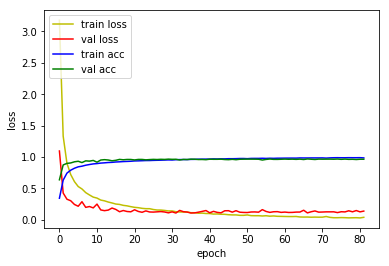

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.1343 - acc: 0.9578
Loss: 0.13427084166467623 Accuracy: 0.9578401

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1900 - acc: 0.4794
Epoch 00001: val_loss improved from inf to 0.78139, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_DO_BN_7_conv_checkpoint/001-0.7814.hdf5
36805/36805 [==============================] - 122s 3ms/sample - loss: 2.1898 - acc: 0.4794 - val_loss: 0.7814 - val_acc: 0.7529
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8021 - acc: 0.7687
Epoch 00002: val_loss improved from 0.78139 to 0.26382, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_DO_BN_7_conv_checkpoint/002-0.2638.hdf5
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.8022 - acc: 0.7687 - val_loss: 0.2638 - val_acc: 0.9215
Epoch 3/500
36800/36805 [=====================

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0745 - acc: 0.9750
Epoch 00027: val_loss did not improve from 0.09626
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0745 - acc: 0.9750 - val_loss: 0.0979 - val_acc: 0.9709
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0750 - acc: 0.9751
Epoch 00028: val_loss did not improve from 0.09626
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0750 - acc: 0.9751 - val_loss: 0.1189 - val_acc: 0.9634
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0680 - acc: 0.9774
Epoch 00029: val_loss did not improve from 0.09626
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0680 - acc: 0.9774 - val_loss: 0.1282 - val_acc: 0.9604
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0635 - acc: 0.9789
Epoch 00030: val_loss improved from 0.09626 to 0.09099, saving model to 

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0197 - acc: 0.9942
Epoch 00056: val_loss did not improve from 0.08987
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0197 - acc: 0.9942 - val_loss: 0.1144 - val_acc: 0.9720
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0252 - acc: 0.9918
Epoch 00057: val_loss did not improve from 0.08987
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0252 - acc: 0.9918 - val_loss: 0.1078 - val_acc: 0.9709
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0198 - acc: 0.9939
Epoch 00058: val_loss did not improve from 0.08987
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0198 - acc: 0.9939 - val_loss: 0.1052 - val_acc: 0.9727
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0198 - acc: 0.9943
Epoch 00059: val_loss did not improve from 0.08987
36805/36805 [========

Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0098 - acc: 0.9971
Epoch 00086: val_loss did not improve from 0.08987
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0098 - acc: 0.9971 - val_loss: 0.1069 - val_acc: 0.9746
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0106 - acc: 0.9970
Epoch 00087: val_loss did not improve from 0.08987
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0106 - acc: 0.9970 - val_loss: 0.1241 - val_acc: 0.9690
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0110 - acc: 0.9968
Epoch 00088: val_loss did not improve from 0.08987
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0110 - acc: 0.9968 - val_loss: 0.1032 - val_acc: 0.9753
Epoch 89/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0114 - acc: 0.9967
Epoch 00089: val_loss did not improve from 0.08987
36805/36805 [========

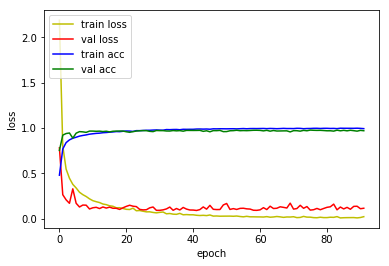

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.1374 - acc: 0.9599
Loss: 0.13736378238579938 Accuracy: 0.95991695

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5851 - acc: 0.5772
Epoch 00001: val_loss improved from inf to 0.63815, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_DO_BN_8_conv_checkpoint/001-0.6382.hdf5
36805/36805 [==============================] - 126s 3ms/sample - loss: 1.5849 - acc: 0.5772 - val_loss: 0.6382 - val_acc: 0.8097
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5622 - acc: 0.8302
Epoch 00002: val_loss improved from 0.63815 to 0.27808, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_DO_BN_8_conv_checkpoint/002-0.2781.hdf5
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.5622 - acc: 0.8302 - val_loss: 0.2781 - val_acc: 0.9166
Epoch 3/500
36800/36805 [====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0465 - acc: 0.9851
Epoch 00026: val_loss did not improve from 0.10633
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0465 - acc: 0.9851 - val_loss: 0.1091 - val_acc: 0.9662
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0404 - acc: 0.9870
Epoch 00027: val_loss did not improve from 0.10633
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0404 - acc: 0.9870 - val_loss: 0.1134 - val_acc: 0.9658
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0359 - acc: 0.9883
Epoch 00028: val_loss did not improve from 0.10633
36805/36805 [==============================] - 113s 3ms/sample - loss: 0.0359 - acc: 0.9883 - val_loss: 0.1462 - val_acc: 0.9602
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0302 - acc: 0.9904
Epoch 00029: val_loss did not improve from 0.10633
36805/36805 [=====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0197 - acc: 0.9937
Epoch 00055: val_loss did not improve from 0.10008
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0197 - acc: 0.9937 - val_loss: 0.1464 - val_acc: 0.9667
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0120 - acc: 0.9962
Epoch 00056: val_loss did not improve from 0.10008
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0120 - acc: 0.9962 - val_loss: 0.1393 - val_acc: 0.9669
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0089 - acc: 0.9974
Epoch 00057: val_loss did not improve from 0.10008
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0089 - acc: 0.9974 - val_loss: 0.1213 - val_acc: 0.9711
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0134 - acc: 0.9961
Epoch 00058: val_loss did not improve from 0.10008
36805/36805 [=====================

Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0056 - acc: 0.9985
Epoch 00085: val_loss did not improve from 0.10008
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0056 - acc: 0.9985 - val_loss: 0.1235 - val_acc: 0.9711
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0096 - acc: 0.9971
Epoch 00086: val_loss did not improve from 0.10008
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0096 - acc: 0.9971 - val_loss: 0.1177 - val_acc: 0.9751
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0063 - acc: 0.9982
Epoch 00087: val_loss did not improve from 0.10008
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0063 - acc: 0.9982 - val_loss: 0.1335 - val_acc: 0.9725
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0055 - acc: 0.9982
Epoch 00088: val_loss did not improve from 0.10008
36805/36805 [========

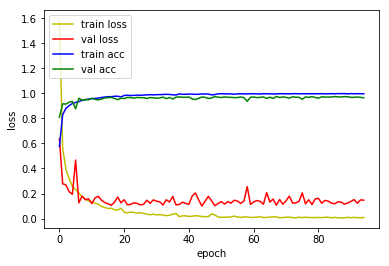

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.1427 - acc: 0.9622
Loss: 0.142686597131742 Accuracy: 0.9622015



In [10]:
base = '1D_CNN_custom_multi_2_GMP_ch_128_DO_BN'

for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    model = build_cnn(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_multi_2_GMP_ch_128_DO_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 9):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_2_GMP_ch_128_DO_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 128)   768         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_33 (Batc (None, 16000, 128)   512         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 128)   0           batch_normalization_v1_33[0][0]  
________________________________________________________

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.3377 - acc: 0.8974
Loss: 0.3376808849698163 Accuracy: 0.89740396

1D_CNN_custom_multi_2_GMP_ch_128_DO_BN_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 128)   768         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_40 (Batc (None, 16000, 128)   512         conv1d_40[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activa

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.1343 - acc: 0.9578
Loss: 0.13427084166467623 Accuracy: 0.9578401

1D_CNN_custom_multi_2_GMP_ch_128_DO_BN_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 128)   768         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_51 (Batc (None, 16000, 128)   512         conv1d_51[0][0]                  
__________________________________________________________________________________________________
activation_51 (Activa

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.1427 - acc: 0.9622
Loss: 0.142686597131742 Accuracy: 0.9622015


In [12]:
for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_custom_multi_2_GMP_ch_128_DO_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 128)   768         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_33 (Batc (None, 16000, 128)   512         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 128)   0           batch_normalization_v1_33[0][0]  
________________________________________________________

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.3513 - acc: 0.8970
Loss: 0.3512570066863008 Accuracy: 0.8969886

1D_CNN_custom_multi_2_GMP_ch_128_DO_BN_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 128)   768         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_40 (Batc (None, 16000, 128)   512         conv1d_40[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activat

4815/4815 [==============================] - 7s 1ms/sample - loss: 0.1840 - acc: 0.9506
Loss: 0.18404149841749315 Accuracy: 0.9505711

1D_CNN_custom_multi_2_GMP_ch_128_DO_BN_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 128)   768         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_51 (Batc (None, 16000, 128)   512         conv1d_51[0][0]                  
__________________________________________________________________________________________________
activation_51 (Activa

4815/4815 [==============================] - 7s 1ms/sample - loss: 0.2031 - acc: 0.9539
Loss: 0.20312970329407526 Accuracy: 0.9538941
